In [1]:
import itertools
import pytz

import numpy as np
from tables import *
from datetime import datetime, timedelta

import pandas as pd

from skyfield import api
from skyfield.sgp4lib import EarthSatellite
from skyfield.framelib import itrs

Open up our reduced/cleaned TLE dataz

In [2]:
h5file = open_file("/data/Indexed_TLE/reduced.h5", mode="r+")

In [3]:
def tle_dataframe(records):
    return pd.DataFrame.from_records(records, columns=["epoch", "norad_id", "tle1", "tle2"])

def get_all_tles(norad_id: int):
    """
    Return a list of record types structured as
    (norad_id: int, epoch_time: float, tle_line_1: bytes, tle_line_2: bytes)
    """
    records = h5file.root.tle_sorted.read_where("norad_id=={}".format(norad_id))
    # Sort records based on time
    return tle_dataframe(sorted(records, key=lambda row: row[0]))

def get_all_ids():
    results = set(h5file.root.tle_sorted.cols.norad_id)
    return results

two_weeks_td = timedelta(days=14)

class TLEManager:
    def __init__(self, norad_id: int):
        self.records = get_all_tles(norad_id)
        self._ts = api.load.timescale()
        
    def get_known_timespan(self):
        """
        Return datetimes corresponding to the first and last TLE epoch values
        in our record set
        """
        times = self.records.epoch.to_numpy()
        return times[0], times[-1]
    
    def get_tle_times(self):
        return self.records.epoch.to_numpy()
    
    def get_compute_windows(self):
        """
        Return a a tuple of epoch times, to a pair of TLE entries
        
        [
          (start_epoch, end_epoch, tle1, tle2)
        ]
        """
        times = self.get_tle_times()
        times_dt = [datetime.utcfromtimestamp(t) for t in times]
        ntle = times.shape[0]
        
        windows = []
        for i in range(ntle):
            # TODO(meawoppl) gross, document me at least....
            
            if i == 0:
                start = times[0]
            else:
                # TLE Gap Check
                if (times_dt[i] - times_dt[i-1]) > two_weeks_td:
                    start = (times_dt[i] - two_weeks_td).timestamp()
                else:
                    start = (times[i-1] + times[i]) /2
                
            
            if i == ntle-1:
                end = times[-1]
            else:
                if (times_dt[i+1] - times_dt[i]) > two_weeks_td:
                    end = (times_dt[i+1] + two_weeks_td).timestamp()
                else:
                    end = (times[i] + times[i+1]) / 2
        
            if (end - start) >  two_weeks_td.total_seconds():
                continue
                
            windows.append((int(round(start)), int(round(end)), self.records.tle1[i], self.records.tle2[i]))
        
        return windows
    
    def _epoch_to_julian(self, time: float) -> float:
        return self._ts.from_datetime(datetime.utcfromtimestamp(time).replace(tzinfo=pytz.utc)).tt
    
    def compute_lat_long_dist(self, start_epoch: int, end_epoch: int, tle1, tle2):
        # Convert the start and end into julian
        start_time_j = self._epoch_to_julian(start_epoch)
        end_time_j = self._epoch_to_julian(end_epoch)
        
        n_time_steps = int(round((end_epoch - start_epoch) / 60))
        
        julian_times = self._ts.tt_jd(np.linspace(start_time_j, end_time_j, n_time_steps))
        epoch_times = np.linspace(start_epoch, end_epoch, n_time_steps)
        
        sat = EarthSatellite(tle1.decode(), tle2.decode())
        lats, longs, dists = sat.at(julian_times).frame_latlon(itrs)
        
        return epoch_times, lats.degrees, longs.degrees, dists.m

    def compute_tlla_sequence(self):
        windows = tlem.get_compute_windows()
        arrayz = []

        for i, (start, end, tle1, tle2) in enumerate(windows):
            tlla = (times, lats, longs, alts) = tlem.compute_lat_long_dist(start, end, tle1, tle2)
            
            tlla = np.vstack(tlla)
            
            arrayz.append(tlla)
            if i>10: break

        return np.hstack(arrayz).astype(np.float32)


In [4]:
# TODO: Precompute this. it takes a while to scrape the whole col...
all_ids = get_all_ids()
len(all_ids)

19404

In [5]:
tlem = TLEManager(list(all_ids)[-300])

In [6]:
windows = tlem.compute_tlla_sequence()

In [7]:
windows.shape

(4, 18714)

Lets really quick check that the windows we compute and the trajectories meet end-to-end for a semi-random data point

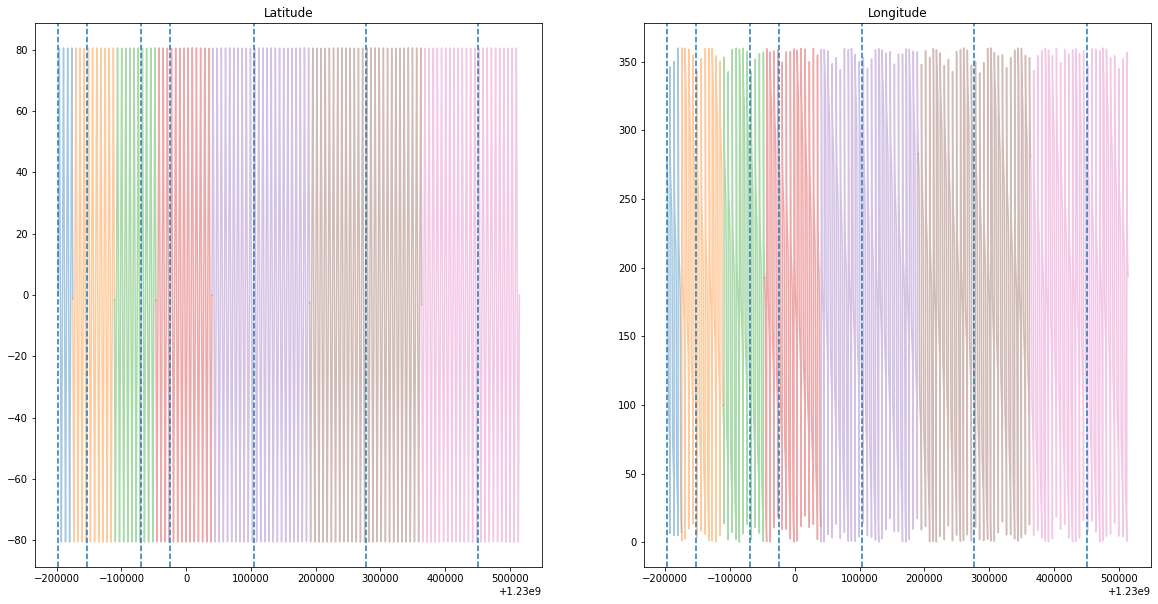

In [8]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20,  10)

tlem = TLEManager(list(all_ids)[-300])
windows = tlem.get_compute_windows()

for i, (start, end, tle1, tle2) in enumerate(windows):
    times, lats, longs, alts = tlem.compute_lat_long_dist(start, end, tle1, tle2)
  
    ax1.set_title("Latitude")
    ax1.plot(times, lats, alpha=0.4)

    ax2.set_title("Longitude")
    ax2.plot(times, longs, alpha=0.4)
    
    if i > 5:
        break

# Add vertical lines where there are TLE epochs
xmin, xmax = ax1.get_xlim()
for t in tlem.get_tle_times():
    if(t > xmin and t < xmax):
        ax1.axvline(t, ls="--")
        ax2.axvline(t, ls="--")

This looks ok at a cursory glance


In [19]:
if not hasattr(h5file.root, "sat"):
    sat_group = h5file.create_group("/", "sat", "Precomputed satellite position cache")
else:
    sat_group = h5file.get_node("/sat")


In [20]:
sat_group

/sat (Group) 'Precomputed satellite position cache'
  children := []

In [10]:
from dask.distributed import Client, as_completed
client = Client()  # start local workers as processes


In [11]:
client

Client Scheduler: tcp://127.0.0.1:34355 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 33.36 GB


In [ ]:
#import concurrent.futures

#with concurrent.futures.ProcessPoolExecutor() as client:
#    future_to_id = {client.submit(TLEManager(idee).compute_tlla_sequence): idee for idee in all_ids}

#    for fut in concurrent.futures.as_completed(future_to_id.keys()):
        
for sat_id in all_ids:
    # Create the hdf5 carray
    print(sat_id)
    sat_tracks = TLEManager(sat_id).compute_tlla_sequence()

    # populate it with the data
    sat_array = Array(sat_group, "s" + str(sat_id), sat_tracks, title="Data for satellite with norad id: %s" % sat_id)


32768
32769
32770
32771
32772
5
32774
32775
32776
32777
32773
11
12
32780
32779
32783
16
32784
32786
32782
32788
20
32789
32791
32792
22
32794
32790
32787
29
32797
32799
32801
32808
32810
45
46
32814
47
39087
50
51
32820
53
32818
39088
58
59
60
32829
32830
63
32832
32833
32834
39090
32842
32843
32846
82
85
32858
39097
32875
107
39099
115
116
117
118
119
32888
32889
122
121
123
125
126
120
128
127
130
131
132
133
134
136
138
32909
32910
141
144
145
32914
147
148
150
152
154
155
32926
159
158
162
163
165
167
32936


In [ ]:
def get_tracks_for_timerange(satellite: int, start: datetime, end: datetime):
    """
    Return a listing of active satellites and positions that spans `start` to `end`
    datetimes. The arrays returned will have `times` elements, which correspond to the
    number of integer minutes between the starting points of the two arrays.
    
    This returns an array:
    @returns np.array (times, 3)
    
    """
    pass
    
    